# Introduction



In this Monte Carlo analysis, our main objective is to demonstrate how the Monte Carlo method can be applied to simulate complex games like Blackjack and extract meaningful statistical insights from repeated trials.

To achieve this, we define the game rules and the dealer’s policy, which follows a standard deterministic behavior (drawing until reaching 17). We then implement different player strategies, in  this case, 2 discrete rule-based policies, to represent distinct decision-making approaches during gameplay.

By running thousands of simulated rounds, we can observe the average net profit and distribution of outcomes (wins, ties, and losses) for each strategy. This approach is particularly valuable because it allows us to assess performance in situations where analytical computation of probabilities is extremely complex. Moreover, it provides a foundation for training AI agents to autonomously learn and refine optimal Blackjack strategies.



# Set up the game.

### Blackjack Game Description (Simplified Version)

Blackjack is a card game played between a player and a dealer. The goal is to reach a hand value as close as possible to 21 points without exceeding it.  

---

**Card Values**
- Cards 2–10 are worth their face value.  
- Jack, Queen and King are each worth 10 points  
- The Ace can count as 1 or 11 whichever benefits the player more.  

---

**Game Rules**
1. Both the player and the dealer start with two cards. The dealer shows one card face up and keeps the other face down.  
2. The player can:
   - Hit → take another card to increase their total.  
   - Stand → keep their current hand and end their turn.  
3. If the player’s total exceeds 21 they bust and lose the round.  
4. After the player finishes, the dealer reveals their hidden card and must hit until reaching at least 17 points  
5. The round outcome is decided as follows:
   - Player busts → loss  
   - Dealer busts → win  
   - Neither busts → closest to 21 wins  
   - Equal totals → tie   

---

**Payout Rules**
In this simplified version (no splitting, insurance, or double down):  
- Win: +\$100  
- Loss: −\$100  
- Tie: no change  




Define the rank and suit of a card.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random

import enum

ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

Define a card and a deck.

Implement shuffle, peek, & deal functions for the deck.

In [3]:
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

 **Set up Blackjack**

### Define logic for evaluating the value of the dealer's hand.

Trickiest part is defining the logic for Aces.

_Dealer Logic will not change much! They must follow a set, predictable course of action._

In [4]:
# This follows the same, official rules every time.
# Still need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # See if using 11 instead of 1 for the Aces gets the 
        # dealer's hand value closer to the [17, 21] range
        
        # The dealer will follow Hard 17 rules.
        # This means the dealer will not hit again if
        # the Ace yields a 17. 
        
        # This also means that Aces initially declared as 11's can
        # be changed to 1's as new cards come.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for evaluating the value of the player's hand.

Trickiest part is defining the logic for Aces. This logic can be implemented in different ways. I opted for an approach that tries to use an Ace as an 11 whenever possible, and only uses the Ace as a 1 when the alternative would make the player bust.

In [7]:
def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace that in the hand is counted as one.
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18,21]
        # Otherwise, use one.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11s, and others to be 1.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for the dealer's turn.

This will not change much since the dealer has to follow a defined protocol when making their moves( the dealer keeps hitting until his total is 17 or more)

In [8]:
def dealer_turn(dealer_hand, deck):
    # Calculate dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (is fixed to official rules)

    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        # hit
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

### Main Blackjack play_game() function.

Can use higher-order functions functionality to pick which player policy to use.

In [ ]:
def play_game(player_policy, num_decks = 2, start_cash = 10000000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    wins=0
    losses=0
    ties=0
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to change when actually training, so that agent tries to win more than tie.)
        bet=100
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        # The current policy does not care about dealer's upcard.
        #dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= bet
            losses+=1
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += bet
            wins+=1
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += bet
                wins+=1
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= bet
                losses+=1
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += bet
                    wins+=1
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= bet
                    losses+=1
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns %net gains/losses of playing
    return (player_cash - start_cash)/(num_rounds*bet)*100 , wins, losses

# Defining Policies


**Discrete Policy 1**

If hand >= 18: player stands.  
Else: Player hits.

In [73]:
def discrete_policy1(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Discrete Policy
    # If hand >= 18, stand. Otherwise, hit.
    while player_value < 18:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

 **Discrete Policy 2**

If hand >= 13: player stands.  
Else: Player hits.

In [74]:
def discrete_policy2(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Discrete Policy
    # If hand >= 13, stand. Otherwise, hit.
    while player_value < 13:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

# Simulation and Results

**Using Discrete Policy 1** 

Run 100000 games of 1 round

Average net return(%): -9.6300
Win(%): 41.4980


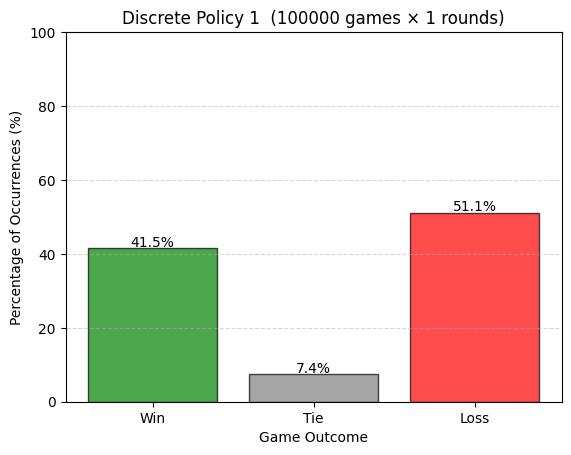

In [77]:
results = {}
num_rds = 1
num_games = 100000
wins=0
losses=0
ties=0
winp=0 #win percentage

# Store individual game outcomes here
returns = []

for i in range(num_games):
    result = play_game(discrete_policy1, num_rounds=num_rds)
    returns.append(result[0])
    wins+=result[1]
    losses+=result[2]
    


winp=wins/(num_games*num_rds) *100
lossp=losses/(num_games*num_rds) *100
tiep=100-(winp+lossp)


# Calculate the average
net_avg = sum(returns) / num_games

results[num_games] = net_avg

print(f"Average net return(%): {net_avg:.4f}")

print(f"Win(%): {winp:.4f}")

categories = ["Win", "Tie", "Loss"]
percentages = [winp, tiep, lossp]

plt.bar(categories, percentages, color=["green", "gray", "red"], alpha=0.7, edgecolor="black")
plt.title(f"Discrete Policy 1  ({num_games} games × {num_rds} rounds)")
plt.ylabel("Percentage of Occurrences (%)")
plt.xlabel("Game Outcome")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, 100)

# Display the value on top of each bar
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.show()

**Using Discrete Policy 2** 

Run 100000 games of 1 round

Average net return(%): -8.3380
Win(%): 42.6610


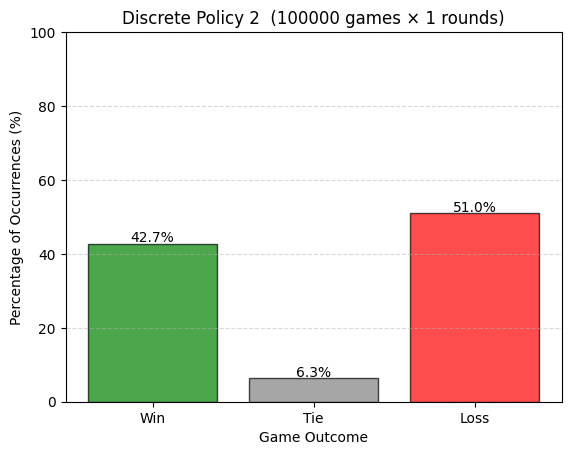

In [80]:
results = {}
num_rds = 1
num_games = 100000
wins=0
losses=0
ties=0
winp=0 #win percentage

# Store individual game outcomes here
returns = []

for i in range(num_games):
    result = play_game(discrete_policy2, num_rounds=num_rds)
    returns.append(result[0])
    wins+=result[1]
    losses+=result[2]
    


winp=wins/(num_games*num_rds) *100
lossp=losses/(num_games*num_rds) *100
tiep=100-(winp+lossp)


# Calculate the average
net_avg = sum(returns) / num_games

results[num_games] = net_avg

print(f"Average net return(%): {net_avg:.4f}")

print(f"Win(%): {winp:.4f}")

categories = ["Win", "Tie", "Loss"]
percentages = [winp, tiep, lossp]

plt.bar(categories, percentages, color=["green", "gray", "red"], alpha=0.7, edgecolor="black")
plt.title(f"Discrete Policy 2  ({num_games} games × {num_rds} rounds)")
plt.ylabel("Percentage of Occurrences (%)")
plt.xlabel("Game Outcome")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, 100)

# Display the value on top of each bar
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.show()

## Result descussion

By comparing the results for the two Discrete Policies, we can observe that Discrete Policy 2 performs slightly better overall than Discrete Policy 1.

The average net return for Discrete Policy 1 is −9.63% of the betted money, while Discrete Policy 2 achieves a higher value of −8.34%. Similarly, the win rate increases from 41.50% to 42.66%. Although both strategies still yield negative returns—meaning the player continues to lose money in the long run—the improvement of roughly 1.3% in win rate and 1.3% in net return suggests that the second policy introduces small but meaningful optimizations in decision-making.

The improvement can be explained by the safer behavior of Discrete Policy 2. Standing on all hands of 13 or higher avoids some unnecessary risks of busting that occur under Policy 1, which continues to hit until reaching 18. This allows the player to preserve more moderate-value hands that still have a chance to beat the dealer, especially when the dealer busts.

Overall, both strategies confirm the house advantage inherent in Blackjack, but also demonstrate how even simple strategy modifications can produce measurable differences when analyzed through Monte Carlo simulation.







